In [1]:
import pathlib
import os
if not "changed_working_directory" in locals():
    changed_working_directory = True
    os.chdir(pathlib.Path().resolve().parent)
    
%load_ext autoreload
%autoreload 2

from tabGAN import TabGAN, TabGANcf, TabGANcfmc
from src import constants as const
import helpers
import scipy

imports_path = "src//imports.ipynb"
tabGAN_path = "tabGAN.py"
utils_path = "utils\\utils.ipynb"

%run "$imports_path"

if const.dir.project() != os.getcwd():
    raise ValueError("Project directory not the same as in global vars")

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

inp1 = keras.Input(shape=(10))
inp2 = keras.Input(shape=(20))
inp3 = keras.Input(shape=(40))
inp4 = keras.Input(shape=(1))
hidden = layers.concatenate([inp1, inp2, inp3])
output = Dense(1, name="output_critic")(hidden)
model2 = Model(inputs=[inp1, [inp2, inp3], inp4], outputs=output)

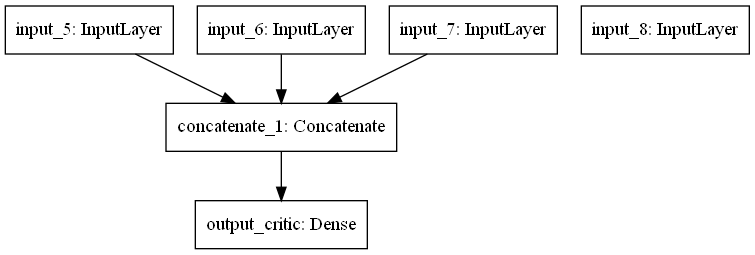

In [16]:
keras.utils.plot_model(model2)

In [17]:
model2([tf.random.normal([1, 10]), [tf.random.normal([1, 20]), tf.random.normal([1, 40])]])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.55249465]], dtype=float32)>

In [18]:
tf.concat([tf.random.normal([1, 10]), tf.concat([tf.random.normal([1, 20]), tf.random.normal([1, 40])],axis=1)], axis=1)

<tf.Tensor: shape=(1, 70), dtype=float32, numpy=
array([[-0.7516189 ,  0.25291297,  0.7927028 ,  0.8682805 ,  1.0678095 ,
         0.64601666, -0.06705347, -0.6070528 ,  0.047532  , -1.3046318 ,
         0.6706024 , -1.5765095 , -1.3346529 , -1.3874321 , -0.9740027 ,
        -0.85958505,  0.5194762 , -0.2616199 , -0.61612844,  1.3417476 ,
        -0.4872492 , -0.12602459,  1.5151867 , -0.7028199 , -1.1146636 ,
         0.03974319, -2.842977  ,  0.4257857 , -0.6841871 ,  1.5574486 ,
        -0.12922701, -0.36316645,  2.646861  , -2.2619035 , -1.7097013 ,
         0.50874007,  2.6023245 ,  1.7672193 ,  0.7656074 , -0.9035207 ,
         0.10021512,  0.9783393 ,  0.8817401 , -0.07592757, -0.39556137,
        -1.1629268 , -0.06453539, -0.57401025,  0.57927406, -0.44647145,
         0.9756735 , -1.5162933 , -0.00722612, -2.2327685 ,  0.50507987,
         0.7298351 , -0.8346201 ,  0.7652272 ,  0.69147605, -1.1080624 ,
        -0.38724583, -0.06684815, -0.15056579,  1.36889   , -0.7439221 ,
  

In [19]:
[i if i < 5 else None for i in range(10)]

[0, 1, 2, 3, 4, None, None, None, None, None]

In [2]:
n_epochs = 20
n_critic = 10
opt_lr = 0.0002
adam_beta1 = 0.5
noise_discrete_unif_max = 0

batch_size = 500
ckpt_every = 1
loss_plot_update_every = 10

retrain = True

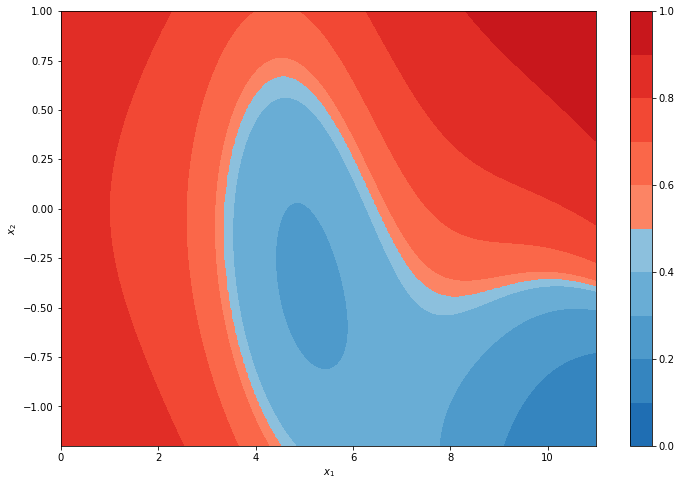

In [3]:
n_cols = 10
# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = matplotlib.cm.get_cmap('Blues_r')(np.linspace(0.2, 0.6, n_cols))
colors2 = matplotlib.cm.get_cmap('Reds')(np.linspace(0.4, 0.8, n_cols))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
cmap_br = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

def classifier_func(x1, x2):
    a = 0.1 * (x1 - 5)**2 + (x2)**2 - 0.5 + 0.2 * tf.sqrt(x1) - 0.1*x1 + 0.005*x1**3 * x2 + 0.5*tf.math.sin(x1) + 0.3*tf.math.cos(x2)
    b = tf.sign(a) * (tf.abs(a))**(1/2)
    return tf.math.sigmoid(b)


fig, ax = plt.subplots(figsize=[12,8])
def plot_heatmap(ax, heat_map_res = 200, incl_axis_labels = True, incl_colorbar = True, ret_contour = True):
    x1 = np.linspace(0, 11, heat_map_res)
    x2 = np.linspace(-1.2, 1, heat_map_res)
    x1_mesh, x2_mesh = np.meshgrid(x1, x2)
    
    y_mesh = classifier_func(x1_mesh, x2_mesh)
    cont1 = ax.contourf(x1_mesh, x2_mesh, y_mesh, levels = np.linspace(0, 1, n_cols + 1), cmap = cmap_br)
    if (incl_axis_labels):
        ax.set_xlabel(r"$x_1$")
        ax.set_ylabel(r"$x_2$")
    if incl_colorbar:
        plt.colorbar(cont1, ax = ax)
    if ret_contour:
        return cont1

plot_heatmap(ax)
plt.savefig(os.path.join(const.dir.images(), "prediction_func_for_cf_testing.svg"))

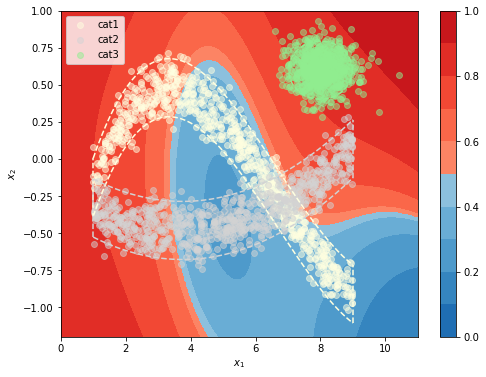

In [4]:
def classifier(data):
    return(classifier_func(data["x1"], data["x2"]))

n_train = 5000

x1_low, x1_high = 1,9
np.random.seed(1)

def sample_x1_given_x3(x3):
    x1_given_cat1_or_cat2 = np.random.uniform(x1_low, x1_high, n_train)
    x1_given_cat3 = np.random.normal(x1_mean_given_x3, sigma_x1 , n_train)
    return np.where(x3 == "cat3", x1_given_cat3, x1_given_cat1_or_cat2)

sigma_x2 = 0.1
sigma_x1 = 0.5
x3 = np.random.choice(["cat1","cat2", "cat3"], n_train)
x1_mean_given_x3 = 8
x2_mean_given_x3 = 0.6
x1 = sample_x1_given_x3(x3)

def mean_x2_given_x1_x3(x1, x3):
    cond_list = [x3 == "cat1", x3 == "cat2", x3 == "cat3"]
    choice_list = [0.01*(x1)**3 - 0.2*x1**2 + x1 - 1, 0.02*x1**2 - 0.15*x1 -0.2, x2_mean_given_x3]
    return np.select(cond_list, choice_list, default=0)

def sample_x2_given_x1_x3(x1,x3, sigma):
    return np.random.normal(mean_x2_given_x1_x3(x1, x3), sigma, n_train)

def conf_int_x2_given_x1_x3(x3, sigma_x1, sigma_x2, alpha = 0.05, n_steps = 100):
    if x3 == "cat1" or x3 == "cat2":
        x1 = np.linspace(x1_low, x1_high, n_steps)
        mean = mean_x2_given_x1_x3(x1, x3)
        return(x1, scipy.stats.norm.interval(1-alpha, loc=mean, scale=sigma_x2))
    elif x3 == "cat3":
        degree = np.linspace(0, np.pi, n_steps)
        x1 = x1_mean_given_x3 + np.cos(degree) * 1.96 *sigma_x1
        x2 = [x2_mean_given_x3 + np.sin(degree) * 1.96 * sigma_x2,
              x2_mean_given_x3 + np.sin(-degree) * 1.96 * sigma_x2]
        return x1, x2
    else:
        raise ValueError("The x3 paramter must be one of the values cat1, cat2 or cat3 and given in string format")

x2 = sample_x2_given_x1_x3(x1, x3, sigma_x2)
df_toy = pd.DataFrame({"x1" : x1, "x2" : x2, "x3" : x3})
df_toy.to_csv(os.path.join(const.dir.data(), "df_toy.csv"), index=False)
category_colors = ["lightyellow", "lightgrey", "lightgreen"]

def plot_confint_x2_given_x1_and_x3(ax, sigma_x1, sigma_x2, alpha = 0.05):
    x1_grid, x2_confint = conf_int_x2_given_x1_x3("cat1", sigma_x1, sigma_x2, alpha =alpha)
    ax.plot(x1_grid, x2_confint[0], c= category_colors[0], linestyle = "dashed")
    ax.plot(x1_grid, x2_confint[1], c = category_colors[0], linestyle = "dashed")
    ax.plot([x1_grid[0], x1_grid[0]], [x2_confint[0][0], x2_confint[1][0]],
            c=category_colors[0], linestyle = "dashed")
    ax.plot([x1_grid[-1], x1_grid[-1]], [x2_confint[0][-1], x2_confint[1][-1]],
            c=category_colors[0], linestyle = "dashed")
    
    x1_grid, x2_confint = conf_int_x2_given_x1_x3("cat2", sigma_x1, sigma_x2, alpha = alpha)
    ax.plot(x1_grid, x2_confint[0], c= category_colors[1], linestyle = "dashed")
    ax.plot(x1_grid, x2_confint[1], c = category_colors[1], linestyle = "dashed")
    ax.plot([x1_grid[0], x1_grid[0]], [x2_confint[0][0], x2_confint[1][0]],
            c=category_colors[1], linestyle = "dashed")
    ax.plot([x1_grid[-1], x1_grid[-1]], [x2_confint[0][-1], x2_confint[1][-1]],
            c=category_colors[1], linestyle = "dashed")
    x1_grid, x2_confint = conf_int_x2_given_x1_x3("cat3", sigma_x1, sigma_x2, alpha=alpha)
    ax.plot(x1_grid, x2_confint[0], c=category_colors[2], linestyle="dashed")
    ax.plot(x1_grid, x2_confint[1], c=category_colors[2], linestyle="dashed")
    
    

fig, ax = plt.subplots(figsize=[8,6])
map_x3_to_col = lambda x3 : np.select([x3 == "cat1", x3 == "cat2", x3 == "cat3"], category_colors)
categories_unique = np.unique(df_toy["x3"])
plot_heatmap(ax)
for i, cat in enumerate(categories_unique):
    df_toy_subset = df_toy.loc[df_toy["x3"] == cat].head(750)
    plt.scatter(df_toy_subset["x1"], df_toy_subset["x2"], color = str(map_x3_to_col(cat)), alpha = 0.5, label = cat)
plot_confint_x2_given_x1_and_x3(ax, sigma_x1, sigma_x2)
plt.legend()
plt.savefig(os.path.join(const.dir.images(), "Syn2D_cf.svg"), dpi=300)

In [ ]:
tgcf_mc = TabGANcfmc(df_toy, n_critic = n_critic, opt_lr = opt_lr, adam_beta1 = adam_beta1,
              quantile_transformation_int = False, quantile_rand_transformation = False,
             noise_discrete_unif_max = noise_discrete_unif_max)

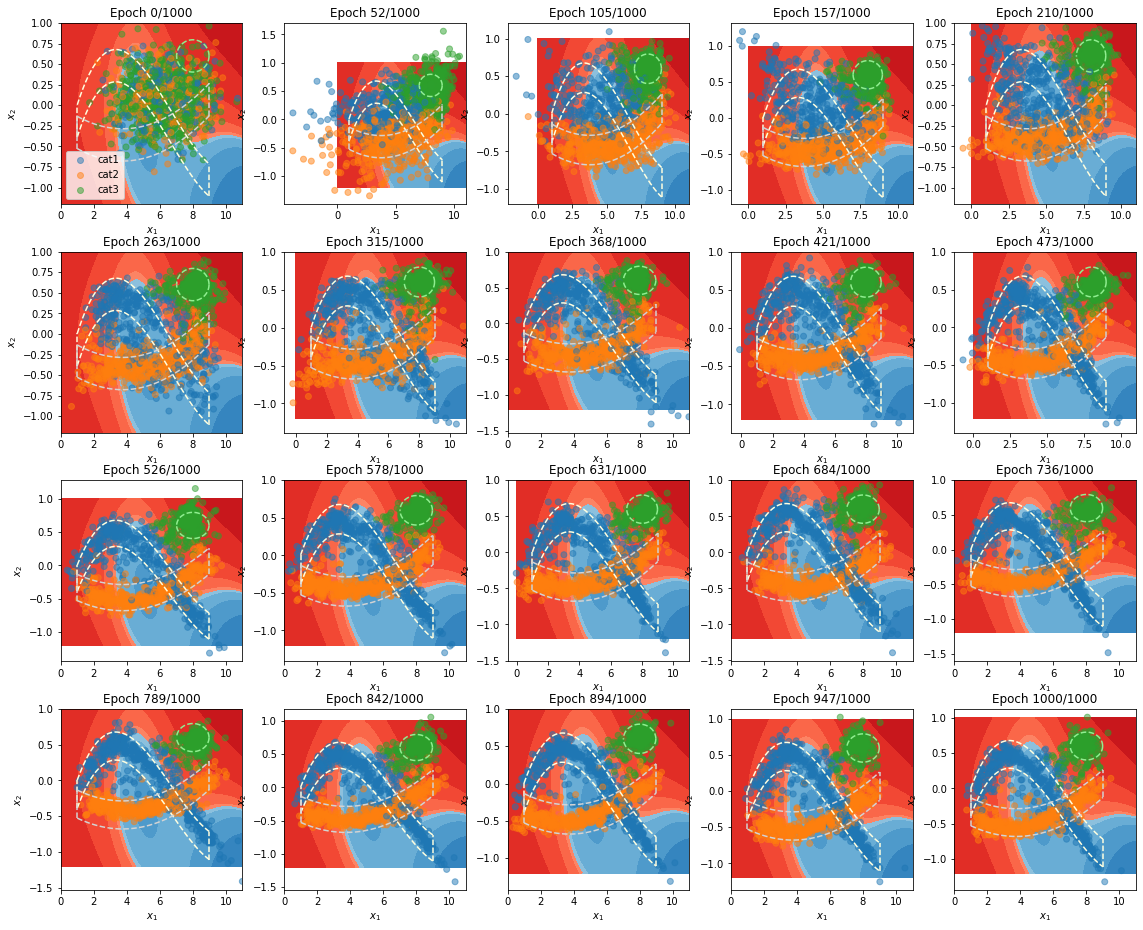

  0%|          | 0/1000 [00:00<?, ?it/s]

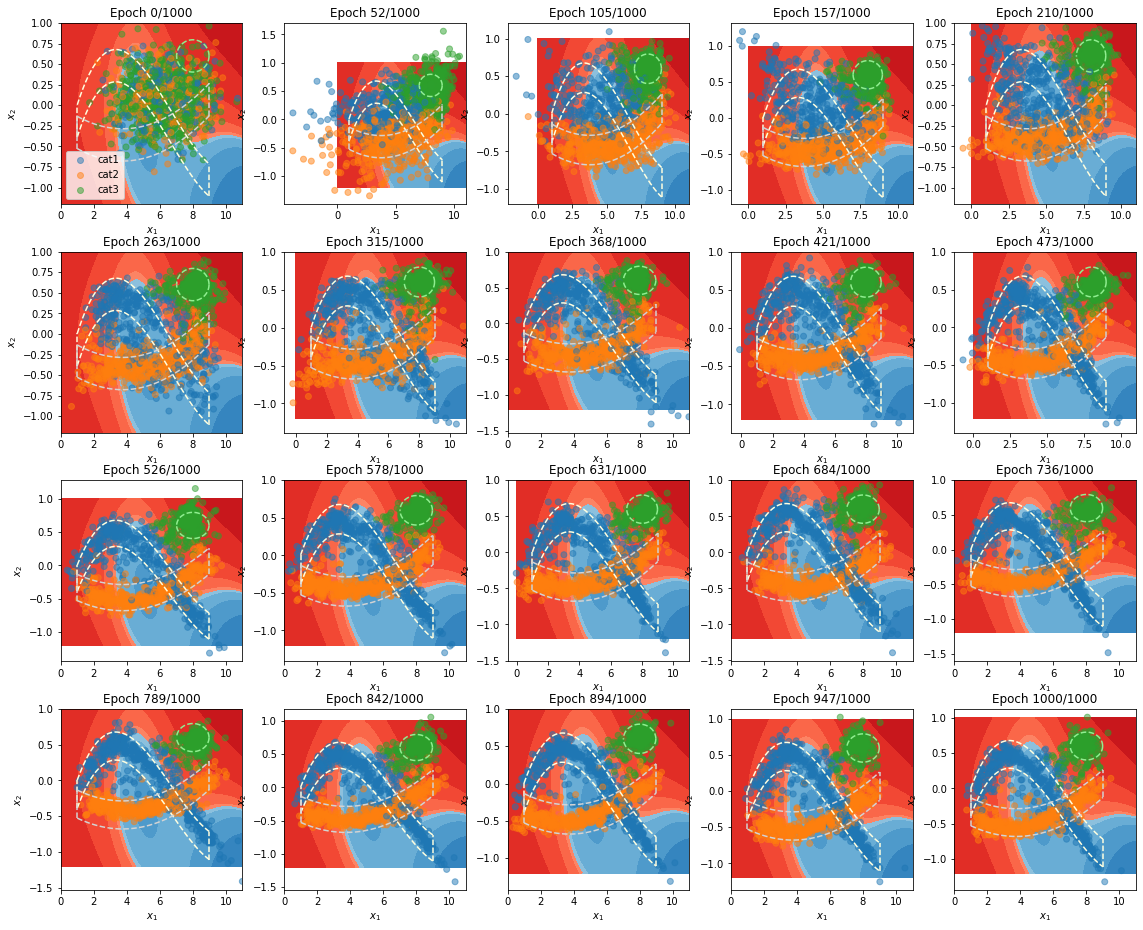

In [98]:
tgcf_mc.train(n_epochs = 1000, batch_size = 500, restart_training = True, plot_loss_update_every = loss_plot_update_every,
             plot_loss_type = "line", progress_bar=True, plot2D_image_real_time=True,
              plot_loss = False, plot2D_n_test=1500,
         plot2D_discrete_col="x3", save_dir = const.dir.images(), filename_plot2D = "syn2D_cf_plot2D.svg",
         filename_plot_loss = "syn2D_cf_train_loss.svg",
         plot2D_background_func = lambda ax : (plot_heatmap(ax, incl_colorbar = False, ret_contour = False),
                                               plot_confint_x2_given_x1_and_x3(ax, sigma_x1, sigma_x2)))

In [25]:
tgcf = TabGANcf(df_toy, classifier=classifier, n_critic = n_critic, opt_lr = opt_lr, adam_beta1 = adam_beta1,
              quantile_transformation_int = False, quantile_rand_transformation = False,
             noise_discrete_unif_max = noise_discrete_unif_max)

[1 3 7]


In [27]:
tgcf.split_transformed_data(tgcf.generate_queries(5)[0])

(<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
 array([[-1.2633995 , -1.2802504 ],
        [ 0.8155508 ,  1.1267086 ],
        [-0.5557303 ,  0.09235273],
        [ 0.66868854, -0.5295466 ],
        [-0.67160755, -1.0099739 ]], dtype=float32)>,
 <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
 array([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], dtype=float32)>)

In [28]:
tgcf.inv_data_transform(*tgcf.split_transformed_data(tgcf.generate_queries(5)[0]))

,x1,x2,x3
0,7.902796,0.737103,cat3
1,2.325117,0.066371,cat1
2,7.100882,-0.427155,cat1
3,8.826986,-0.922289,cat1
4,2.342569,0.393188,cat1


In [31]:
tgcf.classifier(tgcf.inv_data_transform(*tgcf.split_transformed_data(tgcf.generate_queries(5)[0])))

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.28625691, 0.8012013 , 0.90505311, 0.7006732 , 0.30973048])>

In [120]:
a = tf.zeros(1)
a = tf.concat((a, [2]), axis=-1)
a

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 2.], dtype=float32)>

In [5]:
tgcf = TabGANcf(df_toy, classifier=classifier, n_critic = n_critic, opt_lr = opt_lr, adam_beta1 = adam_beta1,
              quantile_transformation_int = False, quantile_rand_transformation = False,
             noise_discrete_unif_max = noise_discrete_unif_max, jit_compile=False,
               query_critic_instance=False,
                 query_critic_classifier_label=True, query_generator_classifier_label=False)

[0.69988293 0.7610362  0.3376263  ... 0.7692746  0.7837729  0.85531678]


''

UnknownError: IndexError: too many indices for array: array is 1-dimensional, but 10 were indexed
Traceback (most recent call last):

  File "C:\Users\Arne\anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\script_ops.py", line 247, in __call__
    return func(device, token, args)

  File "C:\Users\Arne\anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\script_ops.py", line 135, in __call__
    ret = self._func(*args)

  File "C:\Users\Arne\anaconda3\envs\tf\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 620, in wrapper
    return func(*args, **kwargs)

  File "\\sambaad.stud.ntnu.no\arneir\Master-thesis-cf\tabGAN\tabGAN_cf.py", line 51, in <lambda>
    classifier_label = tf.py_function(lambda ixs: self.classifier_label[ixs],

IndexError: too many indices for array: array is 1-dimensional, but 10 were indexed

 [Op:EagerPyFunc]

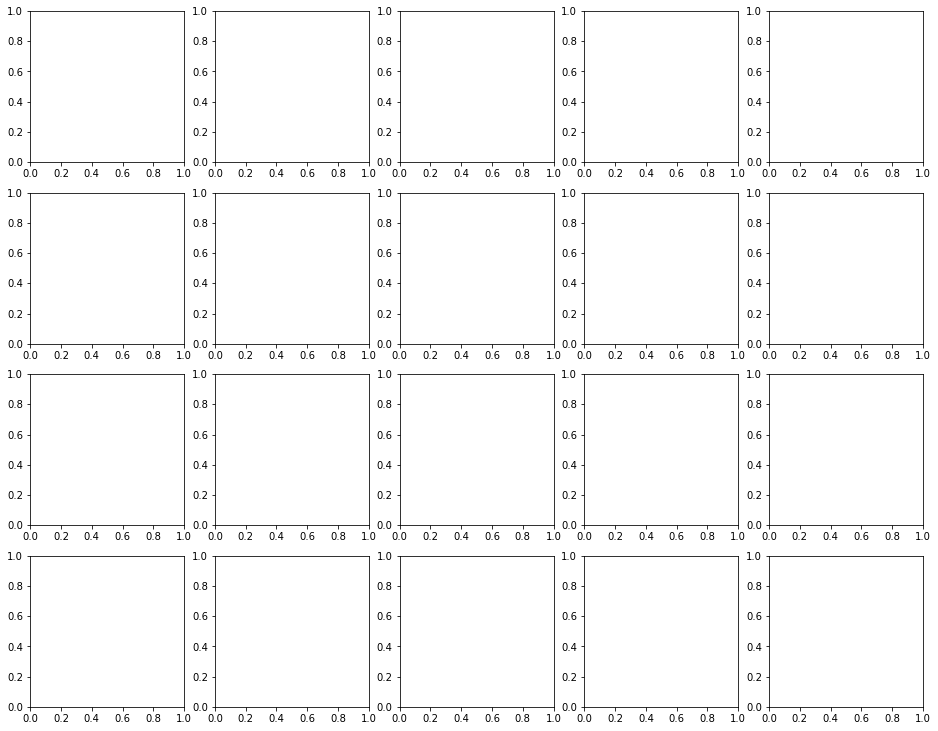

In [56]:
tgcf.train(n_epochs = 1000, batch_size = 500, restart_training = True, plot_loss_update_every = loss_plot_update_every,
             plot_loss_type = "line", progress_bar=True, plot2D_image_real_time=True,
              plot_loss = False, plot2D_n_test=10,
         plot2D_discrete_col="x3", save_dir = const.dir.images(), filename_plot2D = "syn2D_cf_plot2D.svg",
         filename_plot_loss = "syn2D_cf_train_loss.svg",
         plot2D_background_func = lambda ax : (plot_heatmap(ax, incl_colorbar = False, ret_contour = False),
                                               plot_confint_x2_given_x1_and_x3(ax, sigma_x1, sigma_x2)))

In [61]:
queries_test = tgcf.generate_queries(5)
observations = tgcf.inv_data_transform(*tgcf.split_transformed_data(queries_test))
sampled_test = tgcf.sample_scaled(queries=queries_test)

In [63]:
tgcf.sample_scaled(queries=queries_test)

,x1,x2,x3:cat1,x3:cat2,x3:cat3
0,-0.055811,-0.784221,9.996825e-01,3.172627e-04,1.886582e-07
1,1.168070,1.269404,0.000000e+00,0.000000e+00,1.000000e+00
2,0.715492,1.410894,7.853129e-32,0.000000e+00,1.000000e+00
3,1.416742,-2.877208,1.000000e+00,5.186488e-23,2.501435e-26
4,0.770409,1.230509,1.264880e-16,2.386482e-14,1.000000e+00


In [58]:
classifier(observations)

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.82104857, 0.74240152, 0.23938885, 0.40132057, 0.52451399])>

In [59]:
classifier(sampled_test)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.73723495, 0.8206849 , 0.35668513, 0.5632053 , 0.3063007 ],
      dtype=float32)>

In [ ]:
classifier()

In [14]:
%lprun -f fast_non_dominated_sort a = tg.generate_counterfactuals(50, classifier, tg.data.loc[0], n_to_generate = 10000, add_plausibility_objective =True)

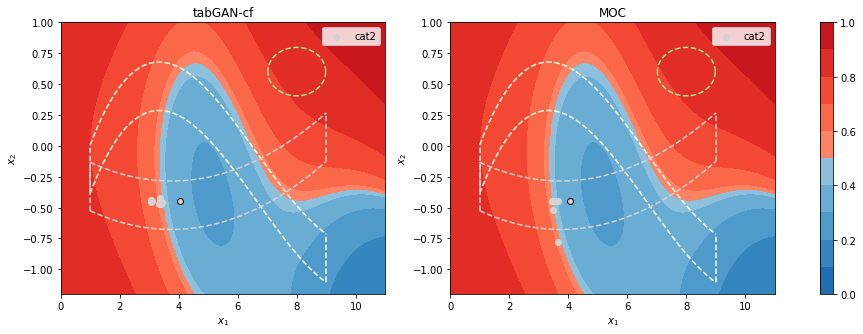

In [194]:
cf_dir = ".//Counterfactuals"
%run "$utils_path"
return_diff = False
compare_counterfactuals(df_toy, x_obs_nr = 89, save_path = "compare_counterfactuals_for_obs1.svg", save_dir=image_dir,
                       only_tabGAN_cf = False, figsize=[16,5])

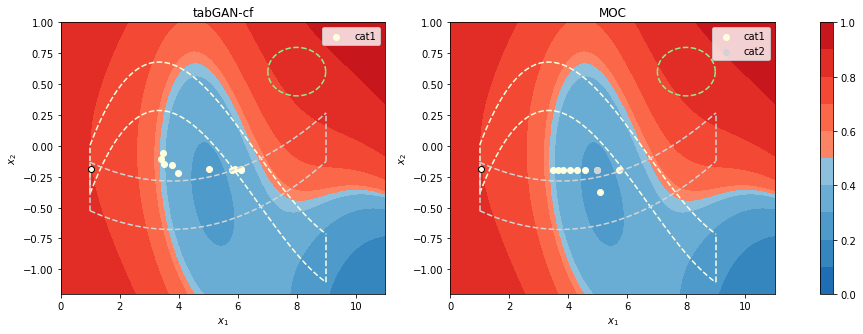

In [192]:
compare_counterfactuals(df_toy, x_obs_nr=243, save_path = "compare_counterfactuals_for_obs2.svg", save_dir=image_dir,
                       only_tabGAN_cf = False, figsize=[16,5])

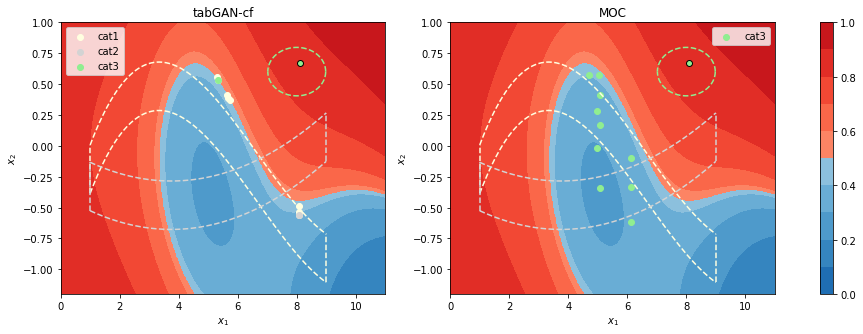

In [197]:
compare_counterfactuals(df_toy, x_obs_nr=11, save_path = "compare_counterfactuals_for_obs3.svg", save_dir=image_dir,
                       only_tabGAN_cf = False,figsize=[16,5])

In [102]:
print(df_toy.iloc[[89, 243, 11]].to_latex(index=False))

\begin{tabular}{rrl}
\toprule
      x1 &        x2 &   x3 \\
\midrule
4.049509 & -0.448952 & cat2 \\
1.038291 & -0.191824 & cat1 \\
8.107074 &  0.669967 & cat3 \\
\bottomrule
\end{tabular}



In [86]:
%run "$utils_path"
%run "$tableGAN_path"
data_adult_train= pd.read_csv('Datasets\\df_adult_edited_train.csv')
data_adult_test= pd.read_csv('Datasets\\df_adult_edited_test.csv')
discrete_columns = data_adult_train.columns[data_adult_train.dtypes == "object"]
data_adult_train[discrete_columns] = data_adult_train[discrete_columns].astype("category")
data_adult_test[discrete_columns] = data_adult_test[discrete_columns].astype("category")

data_adult_train_wo_income = data_adult_train.loc[:,data_adult_train.columns != "income"]

In [87]:
%run "$tableGAN_path"
tg_qt = TableGAN(data_adult_train_wo_income, n_critic = n_critic,
                 adam_lr = adam_lr, adam_beta1 = 0.5, adam_beta2 = 0.999,
              quantile_transformation_int = True, quantile_rand_transformation = False,
             noise_discrete_unif_max = noise_discrete_unif_max)

In [88]:
retrain = True
tic()
if retrain:
    tg_qt.train(n_epochs = 40, batch_size = 500, restart_training = True, loss_plot_update_every = loss_plot_update_every,
                 loss_plot_type = "line", progress_bar=True, plot_loss = False)
toc()

  0%|          | 0/40 [00:00<?, ?it/s]

Elapsed time: 212.471001 seconds.



In [89]:
clf = XGBClassifier(
        tree_method="gpu_hist", enable_categorical=True, use_label_encoder=True, eval_metric = "logloss"
    )

In [90]:
clf.fit(data_adult_train_wo_income, data_adult_train["income"])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=True,
              eval_metric='logloss', gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [91]:
accuracy = accuracy_score(data_adult_test["income"],
                          clf.predict(data_adult_test.loc[:,data_adult_test.columns != "income"]))
auc = roc_auc_score(data_adult_test["income"],
                    clf.predict_proba(data_adult_test.loc[:,data_adult_test.columns != "income"])[:,1])
print("Accuracy:", accuracy)
print("AUC:", auc)

Accuracy: 0.8636786188579018
AUC: 0.9221461029691664


In [92]:
def pred_func(data):
    discrete_columns = data.columns[data.dtypes == "object"]
    data[discrete_columns] = data[discrete_columns].astype("category")
    return clf.predict_proba(data)[:,1]

In [93]:
print(data_adult_train.loc[0:0].to_latex(index=False))

\begin{tabular}{rlrlrllllrrrll}
\toprule
 age &  workclass &  fnlwgt & education &  educational.num & marital.status &   occupation &  race & gender &  capital.gain &  capital.loss &  hours.per.week & native.country & income \\
\midrule
  39 & Government &   77516 & Bachelors &               13 &  Never-married & Adm-clerical & White &   Male &          2174 &             0 &              40 &             US &  <=50K \\
\bottomrule
\end{tabular}



In [94]:
data_adult_train_wo_income.loc[0:0,]

,age,workclass,fnlwgt,education,educational.num,marital.status,occupation,race,gender,capital.gain,capital.loss,hours.per.week,native.country
0,39,Government,77516,Bachelors,13,Never-married,Adm-clerical,White,Male,2174,0,40,US


In [95]:
tic()
df_cf_explanations = tg_qt.generate_counterfactuals(3, pred_func, data_adult_train_wo_income.loc[0:0,], n_to_generate=100000,
                                                   epsilon_num_percent = 0.005)
toc()

Elapsed time: 25.052330 seconds.



In [96]:
df_cf_explanations["Prediction"] = pred_func(df_cf_explanations.loc[:,data_adult_train_wo_income.columns])
df_cf_explanations_transposed =df_cf_explanations.transpose()
df_cf_explanations_transposed.columns = [f"Observation {i+1}" for i in df_cf_explanations_transposed.columns]
df_cf_explanations_transposed

,Observation 1,Observation 2,Observation 3
age,42.0,40.0,39.0
workclass,Government,Government,Government
fnlwgt,76045.65625,37550.546875,150997.953125
education,Bachelors,Bachelors,Bachelors
educational.num,13.0,13.0,13.0
marital.status,Married,Married,Married
occupation,Adm-clerical,Adm-clerical,Adm-clerical
race,White,White,White
gender,Male,Male,Male
capital.gain,0.0,0.0,0.0


In [97]:
print(df_cf_explanations_transposed.to_latex())

\begin{tabular}{llll}
\toprule
{} & Observation 1 & Observation 2 &  Observation 3 \\
\midrule
age             &          42.0 &          40.0 &           39.0 \\
workclass       &    Government &    Government &     Government \\
fnlwgt          &   76045.65625 &  37550.546875 &  150997.953125 \\
education       &     Bachelors &     Bachelors &      Bachelors \\
educational.num &          13.0 &          13.0 &           13.0 \\
marital.status  &       Married &       Married &        Married \\
occupation      &  Adm-clerical &  Adm-clerical &   Adm-clerical \\
race            &         White &         White &          White \\
gender          &          Male &          Male &           Male \\
capital.gain    &           0.0 &           0.0 &            0.0 \\
capital.loss    &           0.0 &           0.0 &            0.0 \\
hours.per.week  &          40.0 &          40.0 &           40.0 \\
native.country  &            US &            US &             US \\
Gower distance  &    